# Words-documents

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

import archetypes as arch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def number_normalizer(tokens):
    """Map all numeric tokens to a placeholder.

    For many applications, tokens that begin with a number are not directly
    useful, but the fact that such a token exists can be relevant.  By applying
    this form of dimensionality reduction, some methods may perform better.
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)

In [3]:
class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))

In [4]:
categories = ['rec.autos', 'rec.sport.hockey', "talk.politics.guns"]

newsgroups = fetch_20newsgroups(categories=categories)
data = newsgroups.data[:]
target = newsgroups.target[:]

# samples = np.random.choice(len(data), 100)
# data = [data[i] for i in samples]
# target = [target[i] for i in samples]

target_names = newsgroups.target_names

vectorizer = NumberNormalizingVectorizer(stop_words="english", min_df=0.02, max_df=0.3)

X = vectorizer.fit_transform(data).toarray()
words = vectorizer.get_feature_names_out()

In [5]:
X.shape

(1740, 1008)

In [6]:
model = arch.BiAA(n_archetypes=(4, 4), max_iter=10_000, n_init=5, random_state=123)
_ = model.fit(X)

In [7]:
model.archetypes_

array([[0.35696302, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.43267611, 0.        ],
       [0.        , 0.        , 0.        , 0.00346157],
       [0.        , 0.64537652, 0.        , 0.        ]])

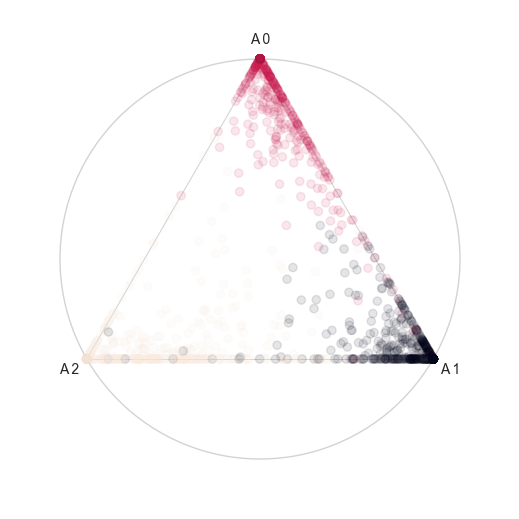

In [9]:
alphas_index = [0, 1, 3]
alphas = pd.DataFrame(model.alphas_)
alphas = alphas.iloc[:, alphas_index]

alphas = alphas.div(alphas.sum(axis=1), axis=0)

a = alphas.idxmax(axis=1)


fig, ax = plt.subplots(figsize=(5, 5))

arch.simplex(alphas, c=target, alpha=0.1, ax=ax)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# fig.savefig('documents.eps', format='eps')
# fig.savefig('documents.png', format='png')
# fig.savefig('documents.pdf', format='pdf')

plt.show()

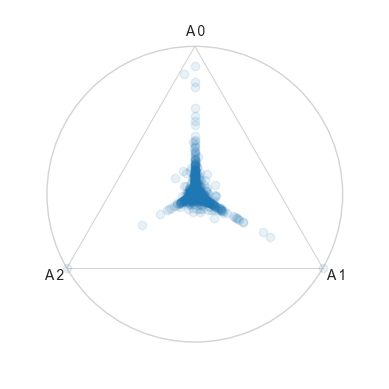

In [10]:
gammas_index = [0, 1, 2]
gammas = pd.DataFrame(model.gammas_.T)
gammas.index = words
gammas = gammas.iloc[:, gammas_index]

# gammas = gammas.div(gammas.sum(axis=1), axis=0)
gammas = gammas.dropna()
g = gammas.idxmax(axis=1)

gammas_names = []
df = pd.DataFrame()
gammas_subset = pd.DataFrame()
for i in range(len(gammas_index)):
    g_i = gammas.sort_values(i, ascending=False).head(10).index.to_list()
    gammas_subset = pd.concat([gammas_subset, gammas.sort_values(i, ascending=False).head(25)])
    df[f"A{i}"] = g_i
    gammas_names += g_i

gammas_subset = gammas_subset[~gammas_subset.index.duplicated(keep='first')]
arch.simplex(gammas, alpha=0.1)
plt.show()

In [11]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
gammas_subset = gammas_subset.div(gammas_subset.sum(axis=1), axis=0)

In [13]:
adj_matrix = cosine_similarity(gammas_subset)
adj_matrix[np.eye(adj_matrix.shape[0], dtype=bool)] = 0

G2 = nx.from_numpy_matrix(adj_matrix)

pos2 = nx.spring_layout(G2, seed=0)

In [14]:
nodes_size = gammas_subset.max(axis=1)
nodes_label = gammas_subset.index

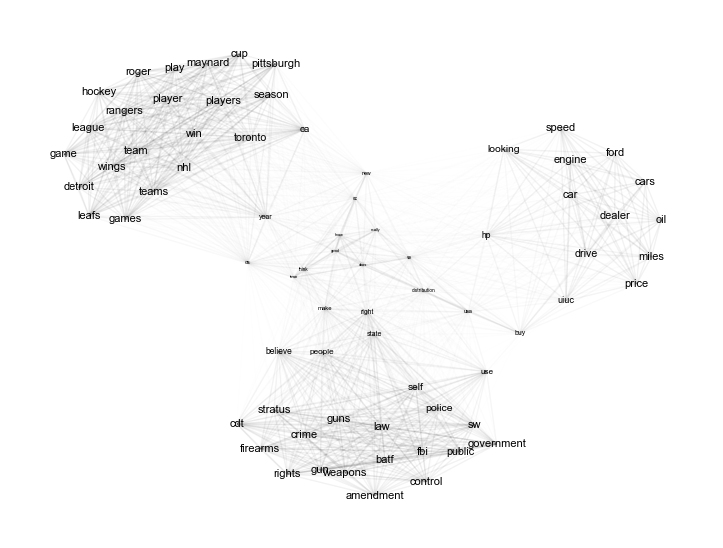

In [15]:
import seaborn as sns

edges = G2.edges(data=True)
nodes = G2.nodes()


[nx.draw_networkx_nodes(G2, pos=pos2, nodelist=[key], node_size=0)
 for key in nodes]
[nx.draw_networkx_edges(G2, pos=pos2, edgelist=[(e1, e2)], alpha=0.05 * values["weight"] ** 5) for e1, e2,
                                                                                                        values in
 edges]
[nx.draw_networkx_labels(G2, pos=pos2, font_size=8 * alpha, alpha=1, labels={node:label})
 for node, label, alpha in zip (nodes, nodes_label, nodes_size)]

plt.axis('off')
plt.subplots_adjust(left=-0.05, right=1.05, bottom=-0.05, top=1.05)

# plt.savefig('words-graph.pdf', format='pdf')
# plt.savefig('words-graph.eps', format='eps')
# plt.savefig('words-graph.png', format='png')

plt.show()